In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Problem Statement 1

Prepare a prediction model for profit of 50_startups data.<br>
Do transformations for getting better predictions of profit and
make a table containing R^2 value for each prepared model.<br>

R&D Spend -- Research and devolop spend in the past few years<br>
Administration -- spend on administration in the past few years<br>
Marketing Spend -- spend on Marketing in the past few years<br>
State -- states from which data is collected<br>
Profit  -- profit of each state in the past few years<br>

In [2]:
startups = pd.read_csv('50_Startups.csv')

In [3]:
startups.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


Since the model doesn't consider textual data we can do One-hot encoding to the categorical x variable State

In [4]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
startups.describe().T

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,39936.3700,73051.080,101602.8000,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,103730.8750,122699.795,144842.1800,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,129300.1325,212716.240,299469.0850,471784.10
Profit,50.0,112012.6392,40306.180338,14681.40,90138.9025,107978.190,139765.9775,192261.83


Checking the distributions of Numerical X variables

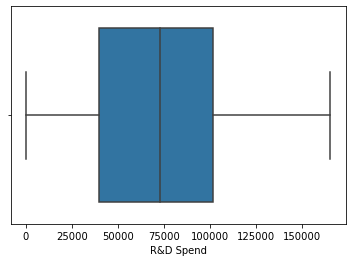

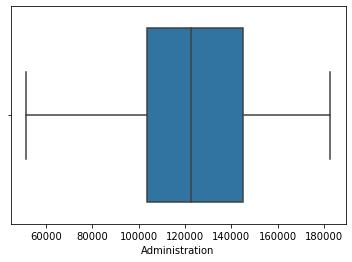

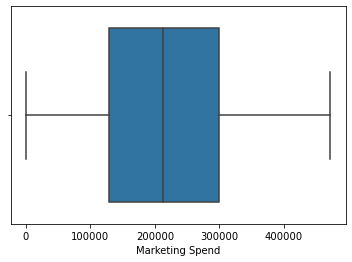

In [6]:
cols = startups.iloc[:,0:3]
for i in cols:    
    sns.boxplot(x=i, data = startups)
    plt.show()

Renaming the column names to make sure that there are no spaces in between

In [7]:
startups['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [8]:
startups = pd.get_dummies(startups, columns=['State'], drop_first=True)

In [9]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   Profit           50 non-null     float64
 4   State_Florida    50 non-null     uint8  
 5   State_New York   50 non-null     uint8  
dtypes: float64(4), uint8(2)
memory usage: 1.8 KB


In [10]:
startups.rename(columns={'Marketing Spend': 'Marketing_Spend', 'R&D Spend': 'RD_Spend', 'State_New York':'State_NewYork'}, inplace=True)

In [11]:
startups.iloc[:,0:4].corr()

,RD_Spend,Administration,Marketing_Spend,Profit
RD_Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing_Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


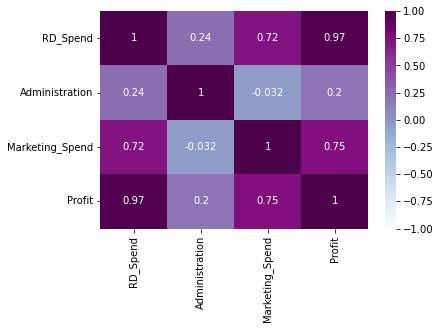

In [12]:
sns.heatmap(startups.iloc[:,0:4].corr(), annot=True, vmax=1, vmin=-1, cmap='BuPu')
plt.show()

From the above heatmap, we can say that:<br>
 -> R&DSpend is highly correlated with the target variable Profit<br>
 -> Marketing Spend is highly correlated with the target variable Profit<br>
 -> Within the independent variables, R&DSpend and Marketing Spend are correlated<br>+
 This is the case of Collinearity

In [13]:
RSquared_table = pd.DataFrame(columns=['Model_Name','AdjRSquared'])

In [14]:
formula = 'Profit~RD_Spend+Administration+Marketing_Spend+State_Florida+State_NewYork'
MLR1 = smf.ols(formula,data=startups).fit()
MLR1.summary()

RSquared_table = RSquared_table.append({'Model_Name': 'Model1', 'AdjRSquared': MLR1.rsquared_adj}, ignore_index=True)

C:\Users\sailo\AppData\Local\Temp\ipykernel_20444\2783963380.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RSquared_table = RSquared_table.append({'Model_Name': 'Model1', 'AdjRSquared': MLR1.rsquared_adj}, ignore_index=True)


#### Let us try to find cook's distance to find any influential points are there in the data

In [15]:
model_influence = MLR1.get_influence()
(c, _) = model_influence.cooks_distance

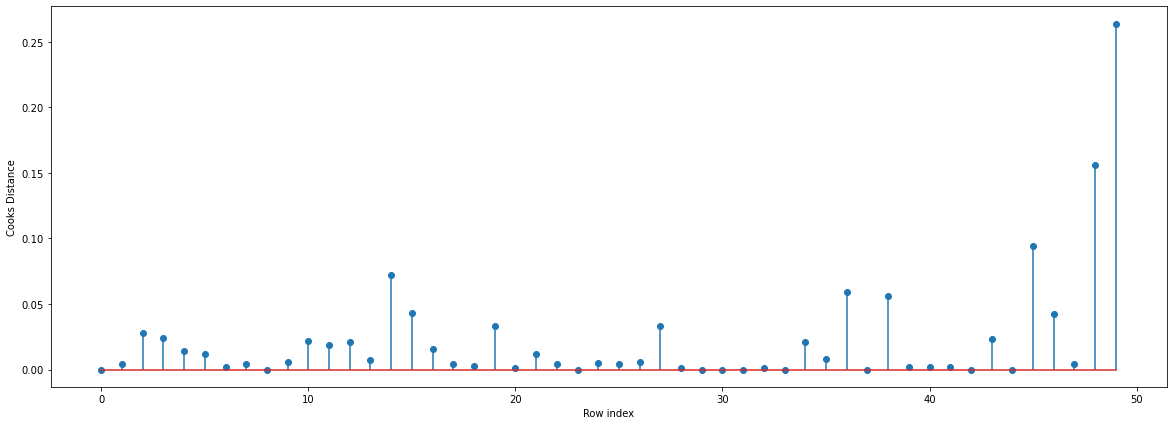

In [16]:
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(startups)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [17]:
(np.argmax(c),np.max(c))

(49, 0.2639594358718263)

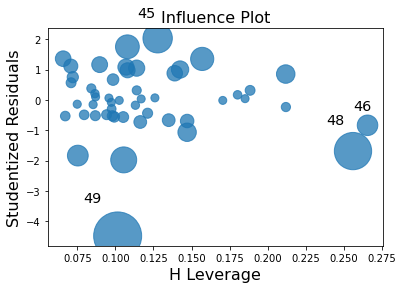

In [18]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(MLR1)
plt.show()

#### In the above plot we can see that 48 and 49 seem to influence our model coefficients hence let's try to remove them and try re-running the model

In [19]:
k = startups.shape[1]
n = startups.shape[0]
leverage_cutoff = 3*((k + 1)/n)
leverage_cutoff

0.42000000000000004

In [20]:
startups[startups.index.isin([49, 48])]

,RD_Spend,Administration,Marketing_Spend,Profit,State_Florida,State_NewYork
48,542.05,51743.15,0.00,35673.41,0,1
49,0.00,116983.80,45173.06,14681.40,0,0


In [21]:
startups1 = startups.copy()

In [22]:
startups1 = startups1.drop(startups1.index[[48,49]],axis=0).reset_index()
startups1 = startups1.drop(['index'],axis=1)
startups1.head()

,RD_Spend,Administration,Marketing_Spend,Profit,State_Florida,State_NewYork
0,165349.20,136897.80,471784.10,192261.83,0,1
1,162597.70,151377.59,443898.53,191792.06,0,0
2,153441.51,101145.55,407934.54,191050.39,1,0
3,144372.41,118671.85,383199.62,182901.99,0,1
4,142107.34,91391.77,366168.42,166187.94,1,0


In [23]:
formula = 'Profit~RD_Spend+Administration+Marketing_Spend+State_Florida+State_NewYork'
finalMLR = smf.ols(formula,data=startups1).fit()
finalMLR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     217.6
Date:                Sun, 17 Sep 2023   Prob (F-statistic):           7.02e-29
Time:                        21:31:51   Log-Likelihood:                -493.23
No. Observations:                  48   AIC:                             998.5
Df Residuals:                      42   BIC:                             1010.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.939e+04   6093.634      9.746      0.000    4.71e+04    7.17e+04
RD_Spend            0.7888      0.037     21.160      0.000       0.714       0.864
Administration     -0.0621      0.045     -1.381      0.174      -0.153       0.029
Marketing_Spend     0.0179      0.014      1.275      0.209      -0.010       0.046
State_Florida   -1150.1897   2712.520     -0.424      0.674   -6624.276    4323.896
State_NewYork    -665.7875   2678.779     -0.249      0.805   -6071.783    4740.208
==============================================================================
Omnibus:                        0.267   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.453
Skew:                           0.108   Prob(JB):                        0.797
Kurtosis:                       2.576   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
ybar = finalMLR.predict(startups1)

In [25]:
predictions = pd.concat([startups1['Profit'],ybar],axis=1)

In [26]:
predictions.head()

,Profit,0
0,192261.83,189087.074698
1,191792.06,186183.370112
2,191050.39,180288.581216
3,182901.99,172087.545966
4,166187.94,171206.768166


In [27]:
RSquared_table = RSquared_table.append({'Model_Name': 'Model2', 'AdjRSquared': finalMLR.rsquared_adj}, ignore_index=True)

C:\Users\sailo\AppData\Local\Temp\ipykernel_20444\3668945480.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RSquared_table = RSquared_table.append({'Model_Name': 'Model2', 'AdjRSquared': finalMLR.rsquared_adj}, ignore_index=True)


In [28]:
RSquared_table

,Model_Name,AdjRSquared
0,Model1,0.945156
1,Model2,0.958413


### Problem Statement 2

ToyotaCorolla.csv has other characters that don't support utf-8 hence used the below encoding 

In [29]:
corolla = pd.read_csv('ToyotaCorolla.csv', encoding='ISO-8859-1')

In [30]:
corolla.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'cc', 'Doors',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Tow_Bar'],
      dtype='object')

In [31]:
corolla.shape

(1436, 38)

Taking only necessary columns for the problem

In [32]:
corolla = corolla[['Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax','Weight','Price']]

In [33]:
corolla.head()

,Age_08_04,KM,HP,cc,Doors,Gears,Quarterly_Tax,Weight,Price
0,23,46986,90,2000,3,5,210,1165,13500
1,23,72937,90,2000,3,5,210,1165,13750
2,24,41711,90,2000,3,5,210,1165,13950
3,26,48000,90,2000,3,5,210,1165,14950
4,30,38500,90,2000,3,5,210,1170,13750


In [34]:
corolla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age_08_04      1436 non-null   int64
 1   KM             1436 non-null   int64
 2   HP             1436 non-null   int64
 3   cc             1436 non-null   int64
 4   Doors          1436 non-null   int64
 5   Gears          1436 non-null   int64
 6   Quarterly_Tax  1436 non-null   int64
 7   Weight         1436 non-null   int64
 8   Price          1436 non-null   int64
dtypes: int64(9)
memory usage: 101.1 KB


In [35]:
corolla['Gears'].value_counts()

5    1390
6      43
3       2
4       1
Name: Gears, dtype: int64

In [36]:
corolla['Doors'].value_counts()

5    674
3    622
4    138
2      2
Name: Doors, dtype: int64

In [37]:
corolla['Quarterly_Tax'].value_counts()

85     613
69     559
185     96
19      72
100     19
234     19
210     18
64      18
197     14
283      3
72       3
163      1
40       1
Name: Quarterly_Tax, dtype: int64

Converting necessary colmuns into categorical 

In [38]:
corolla['Gears'] = corolla['Gears'].astype('category')
corolla['Doors'] = corolla['Doors'].astype('category')

In [39]:
corolla = pd.get_dummies(corolla,columns=['Doors','Gears'],drop_first=True)
corolla.head()

,Age_08_04,KM,HP,cc,Quarterly_Tax,Weight,Price,Doors_3,Doors_4,Doors_5,Gears_4,Gears_5,Gears_6
0,23,46986,90,2000,210,1165,13500,1,0,0,0,1,0
1,23,72937,90,2000,210,1165,13750,1,0,0,0,1,0
2,24,41711,90,2000,210,1165,13950,1,0,0,0,1,0
3,26,48000,90,2000,210,1165,14950,1,0,0,0,1,0
4,30,38500,90,2000,210,1170,13750,1,0,0,0,1,0


In [40]:
corolla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age_08_04      1436 non-null   int64
 1   KM             1436 non-null   int64
 2   HP             1436 non-null   int64
 3   cc             1436 non-null   int64
 4   Quarterly_Tax  1436 non-null   int64
 5   Weight         1436 non-null   int64
 6   Price          1436 non-null   int64
 7   Doors_3        1436 non-null   uint8
 8   Doors_4        1436 non-null   uint8
 9   Doors_5        1436 non-null   uint8
 10  Gears_4        1436 non-null   uint8
 11  Gears_5        1436 non-null   uint8
 12  Gears_6        1436 non-null   uint8
dtypes: int64(7), uint8(6)
memory usage: 87.1 KB


In [41]:
corolla.describe().T

,count,mean,std,min,25%,50%,75%,max
Age_08_04,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Quarterly_Tax,1436.0,87.122563,41.128611,19.0,69.0,85.0,85.00,283.0
Weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Doors_3,1436.0,0.433148,0.495683,0.0,0.0,0.0,1.00,1.0
Doors_4,1436.0,0.096100,0.294831,0.0,0.0,0.0,0.00,1.0
Doors_5,1436.0,0.469359,0.499234,0.0,0.0,0.0,1.00,1.0


In [42]:
corolla[corolla.duplicated()].shape

(1, 13)

In [43]:
corolla[corolla.duplicated()]

,Age_08_04,KM,HP,cc,Quarterly_Tax,Weight,Price,Doors_3,Doors_4,Doors_5,Gears_4,Gears_5,Gears_6
113,8,13253,116,2000,234,1320,24950,0,0,1,0,1,0


In [44]:
corolla = corolla.drop_duplicates()

In [45]:
corolla.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1435 entries, 0 to 1435
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age_08_04      1435 non-null   int64
 1   KM             1435 non-null   int64
 2   HP             1435 non-null   int64
 3   cc             1435 non-null   int64
 4   Quarterly_Tax  1435 non-null   int64
 5   Weight         1435 non-null   int64
 6   Price          1435 non-null   int64
 7   Doors_3        1435 non-null   uint8
 8   Doors_4        1435 non-null   uint8
 9   Doors_5        1435 non-null   uint8
 10  Gears_4        1435 non-null   uint8
 11  Gears_5        1435 non-null   uint8
 12  Gears_6        1435 non-null   uint8
dtypes: int64(7), uint8(6)
memory usage: 98.1 KB


In [46]:
corollaForm = 'Price~Age_08_04+KM+HP+cc+Quarterly_Tax+Weight+Doors_3+Doors_4+Doors_5+Gears_4+Gears_5+Gears_6'
corollaMLR1 = smf.ols(corollaForm,data=corolla).fit()

In [47]:
corollaMLR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     746.6
Date:                Sun, 17 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:31:51   Log-Likelihood:                -12364.
No. Observations:                1435   AIC:                         2.475e+04
Df Residuals:                    1422   BIC:                         2.482e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4707.2553   1770.582     -2.659      0.008   -8180.489   -1234.022
Age_08_04      -121.6668      2.621    -46.421      0.000    -126.808    -116.525
KM               -0.0208      0.001    -16.556      0.000      -0.023      -0.018
HP               31.5844      2.849     11.085      0.000      25.995      37.173
cc               -0.1269      0.090     -1.408      0.159      -0.304       0.050
Quarterly_Tax     3.7223      1.313      2.835      0.005       1.147       6.298
Weight           17.1573      1.086     15.793      0.000      15.026      19.288
Doors_3        -496.1711    951.614     -0.521      0.602   -2362.890    1370.547
Doors_4        -307.6866    957.331     -0.321      0.748   -2185.619    1570.246
Doors_5        -501.4454    951.988     -0.527      0.598   -2368.897    1366.007
Gears_4        3169.3236   1646.068      1.925      0.054     -59.659    6398.306
Gears_5        2403.5303    952.146      2.524      0.012     535.768    4271.292
Gears_6        2940.6325    976.345      3.012      0.003    1025.401    4855.864
==============================================================================
Omnibus:                      156.661   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1080.756
Skew:                          -0.229   Prob(JB):                    2.07e-235
Kurtosis:                       7.227   Cond. No.                     5.14e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
vif = pd.DataFrame()
variables = corolla[['Age_08_04', 'KM', 'HP', 'cc', 'Quarterly_Tax','Weight']]
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns

In [49]:
vif

,VIF,features
0,14.600478,Age_08_04
1,7.588089,KM
2,62.674213,HP
3,17.112461,cc
4,10.162655,Quarterly_Tax
5,112.102308,Weight


#### As we can see that Weight is impacting more since it has very high VIF, hence we can try removing it

In [50]:
vif = pd.DataFrame()
variables = corolla[['Age_08_04', 'KM', 'HP', 'cc', 'Quarterly_Tax']]
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns

In [51]:
vif

,VIF,features
0,13.433138,Age_08_04
1,7.569422,KM
2,17.383943,HP
3,15.996832,cc
4,6.804130,Quarterly_Tax


In [52]:
corollaForm = 'Price~Age_08_04+KM+HP+cc+Quarterly_Tax+Doors_3+Doors_4+Doors_5+Gears_4+Gears_5+Gears_6'
corollaMLR2 = smf.ols(corollaForm,data=corolla).fit()

In [53]:
corollaMLR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     674.1
Date:                Sun, 17 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:31:51   Log-Likelihood:                -12480.
No. Observations:                1435   AIC:                         2.498e+04
Df Residuals:                    1423   BIC:                         2.505e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.264e+04   1504.906      8.401      0.000    9690.511    1.56e+04
Age_08_04      -136.4029      2.654    -51.387      0.000    -141.610    -131.196
KM               -0.0198      0.001    -14.608      0.000      -0.023      -0.017
HP               43.4170      2.979     14.573      0.000      37.573      49.261
cc                0.1094      0.096      1.136      0.256      -0.080       0.298
Quarterly_Tax    15.8326      1.155     13.706      0.000      13.567      18.099
Doors_3        -714.4991   1031.232     -0.693      0.489   -2737.397    1308.399
Doors_4        -684.6150   1037.214     -0.660      0.509   -2719.248    1350.018
Doors_5        -391.3656   1031.718     -0.379      0.704   -2415.218    1632.487
Gears_4        2979.2018   1783.928      1.670      0.095    -520.210    6478.614
Gears_5        1660.4538   1030.657      1.611      0.107    -361.316    3682.223
Gears_6        2278.2297   1057.167      2.155      0.031     204.457    4352.002
==============================================================================
Omnibus:                      219.376   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.437
Skew:                           0.707   Prob(JB):                    4.24e-179
Kurtosis:                       6.426   Cond. No.                     4.87e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
corollapredictions = pd.concat([corolla['Price']],axis=1)

In [55]:
corollapredictions['Predicted_values'] = corollaMLR1.predict(corolla)

In [56]:
corollapredictions

,Price,Predicted_values
0,13500,16784.179980
1,13750,16244.980788
2,13950,16772.114948
3,14950,16398.111074
4,13750,16194.617395
...,...,...
1431,7500,8772.555587
1432,10845,8268.062804
1433,8500,8430.952349
1434,7250,8554.696918
